# Kaggle TGS Salt Identification Challenge U-Net

This notebook provides a simple exploration of the dataset for the Kaggle TGS Salt Identification Challenge

Some code from: https://www.kaggle.com/dingli/seismic-data-analysis-with-u-net

## Setup

In [2]:
# Standard python packages
import os
import sys

# Other package imports
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from sklearn.model_selection import train_test_split

from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Input, BatchNormalization, Concatenate
from keras.layers.core import Dropout
from keras.layers.convolutional import Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.models import Model, load_model
from keras.optimizers import Adam

import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

Using TensorFlow backend.


Setup some global settings and configuration

In [3]:
project_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))
data_folder = os.path.join(project_root, 'data')
data_folder_raw = os.path.join(data_folder, 'raw')
src_folder = os.path.join(project_root, 'src')

train_path = os.path.join(data_folder_raw, 'train')
train_images_path = os.path.join(train_path, 'images')
train_masks_path = os.path.join(train_path, 'masks')
train_file = os.path.join(data_folder_raw, 'train.csv')

test_path = os.path.join(data_folder_raw, 'test')
test_images_path = os.path.join(test_path, 'images')

depth_file = os.path.join(data_folder_raw, 'depths.csv')

# Other parameters / shared functions
img_size_ori = 101
img_size_target = 128

def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    #res = np.zeros((img_size_target, img_size_target), dtype=img.dtype)
    #res[:img_size_ori, :img_size_ori] = img
    #return res
    
def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)
    #return img[:img_size_ori, :img_size_ori]

This notebook uses the shared package however first we need to ensure it is available (otherwise you get an error about the module not being found). You can either run setup.py as discussed in the readme to install the package or modify the path to include the src folder.

In [8]:
# Explicitly set path so don't need to run setup.py - if we have multiple copies of 
# the code we would otherwise need to setup a seperate environment for each to
# ensure the code pointers are correct.
sys.path.insert(0, src_folder)

from tgssalt_challenge.submission import RLenc
from tgssalt_challenge.scoring import iou_metric
from tgssalt_challenge.unet import UNet

## Load data
Look at the train file that contains image id's along with a mask of salt regions

In [18]:
train_df = pd.read_csv(train_file, index_col="id", usecols=[0])
depths_df = pd.read_csv(depth_file, index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

In [19]:
train_df["images"] = [np.array(load_img(os.path.join(train_images_path, "{}.png").format(idx), color_mode="grayscale")) / 255 for idx in tqdm_notebook(train_df.index)]

In [20]:
train_df["masks"] = [np.array(load_img(os.path.join(train_masks_path, "{}.png").format(idx), color_mode="grayscale")) / 255 for idx in tqdm_notebook(train_df.index)]

## Calculating the salt coverage and salt coverage classes
Counting the number of salt pixels in the masks and dividing them by the image size. Also create 11 coverage classes, -0.1 having no salt at all to 1.0 being salt only. Plotting the distribution of coverages and coverage classes, and the class against the raw coverage.

In [21]:
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)

In [22]:
def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
        
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)

## Create train/validation split stratified by salt coverage
Using the salt coverage as a stratification criterion. Also show an image to check for correct upsampling.

In [23]:
ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
    train_df.index.values,
    np.array(train_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    np.array(train_df.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    train_df.coverage.values,
    train_df.z.values,
    test_size=0.2, stratify=train_df.coverage_class, random_state=1337)

c:\applications\miniconda3\envs\tensorflow-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


## Data augmentation
Add a flipped version of the images

In [24]:
x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)

## Build Model

In [26]:
model = UNet((img_size_target,img_size_target,1),start_ch=16,depth=5,batchnorm=True)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [27]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_29 (Conv2D)              (None, 128, 128, 16) 160         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_23 (BatchNo (None, 128, 128, 16) 64          conv2d_29[0][0]                  
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 128, 128, 16) 2320        batch_normalization_23[0][0]     
__________________________________________________________________________________________________
batch_norm

In [28]:
print(x_train.shape)

(6400, 128, 128, 1)


## Training

In [16]:
early_stopping = EarlyStopping(patience=10, verbose=1)
model_checkpoint = ModelCheckpoint("./U-Net-keras.model", save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000005, verbose=1)

epochs = 200
batch_size = 32

history = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping, model_checkpoint, reduce_lr],
                    verbose=1)

Train on 6400 samples, validate on 800 samples
Epoch 1/200
6400/6400 [==============================] - 39s 6ms/step - loss: 0.3521 - acc: 0.8652 - val_loss: 0.3757 - val_acc: 0.8705

Epoch 00001: val_loss improved from inf to 0.37569, saving model to ./keras.model
Epoch 2/200
6400/6400 [==============================] - 38s 6ms/step - loss: 0.2766 - acc: 0.8865 - val_loss: 0.7321 - val_acc: 0.6535

Epoch 00002: val_loss did not improve from 0.37569
Epoch 3/200
6400/6400 [==============================] - 38s 6ms/step - loss: 0.2574 - acc: 0.8929 - val_loss: 0.4064 - val_acc: 0.8488

Epoch 00003: val_loss did not improve from 0.37569
Epoch 4/200
6400/6400 [==============================] - 38s 6ms/step - loss: 0.2399 - acc: 0.9003 - val_loss: 0.6800 - val_acc: 0.7821

Epoch 00004: val_loss did not improve from 0.37569
Epoch 5/200
6400/6400 [==============================] - 38s 6ms/step - loss: 0.2102 - acc: 0.9109 - val_loss: 0.2606 - val_acc: 0.8874

Epoch 00005: val_loss improved fr

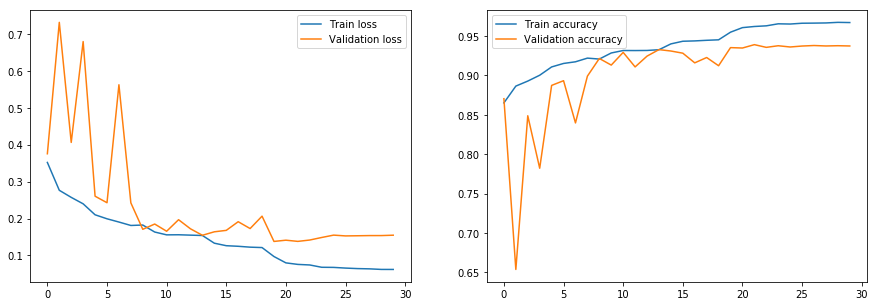

In [17]:
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_loss.legend()
ax_acc.plot(history.epoch, history.history["acc"], label="Train accuracy")
ax_acc.plot(history.epoch, history.history["val_acc"], label="Validation accuracy")
ax_acc.legend()

## Predict the validation set

In [29]:
# model = load_model("./U-Net-keras.model")

In [30]:
preds_valid = model.predict(x_valid).reshape(-1, img_size_target, img_size_target)
preds_valid = np.array([downsample(x) for x in preds_valid])
mask_valid = np.array([downsample(x) for x in y_valid])

c:\applications\miniconda3\envs\tensorflow-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


### Scoring
Score the model and do a threshold optimization by the best IoU.

In [32]:
thresholds = np.linspace(0, 1, 50)
ious = np.array([iou_metric_batch(mask_valid, np.int32(preds_valid > threshold)) for threshold in tqdm_notebook(thresholds)])

In [33]:
threshold_best_index = np.argmax(ious[9:-10]) + 9
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

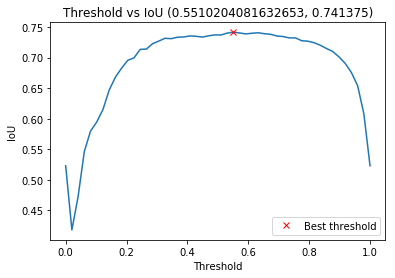

In [34]:
plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

## Sanity check with adjusted threshold
Again some sample images with the adjusted threshold.

c:\applications\miniconda3\envs\tensorflow-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


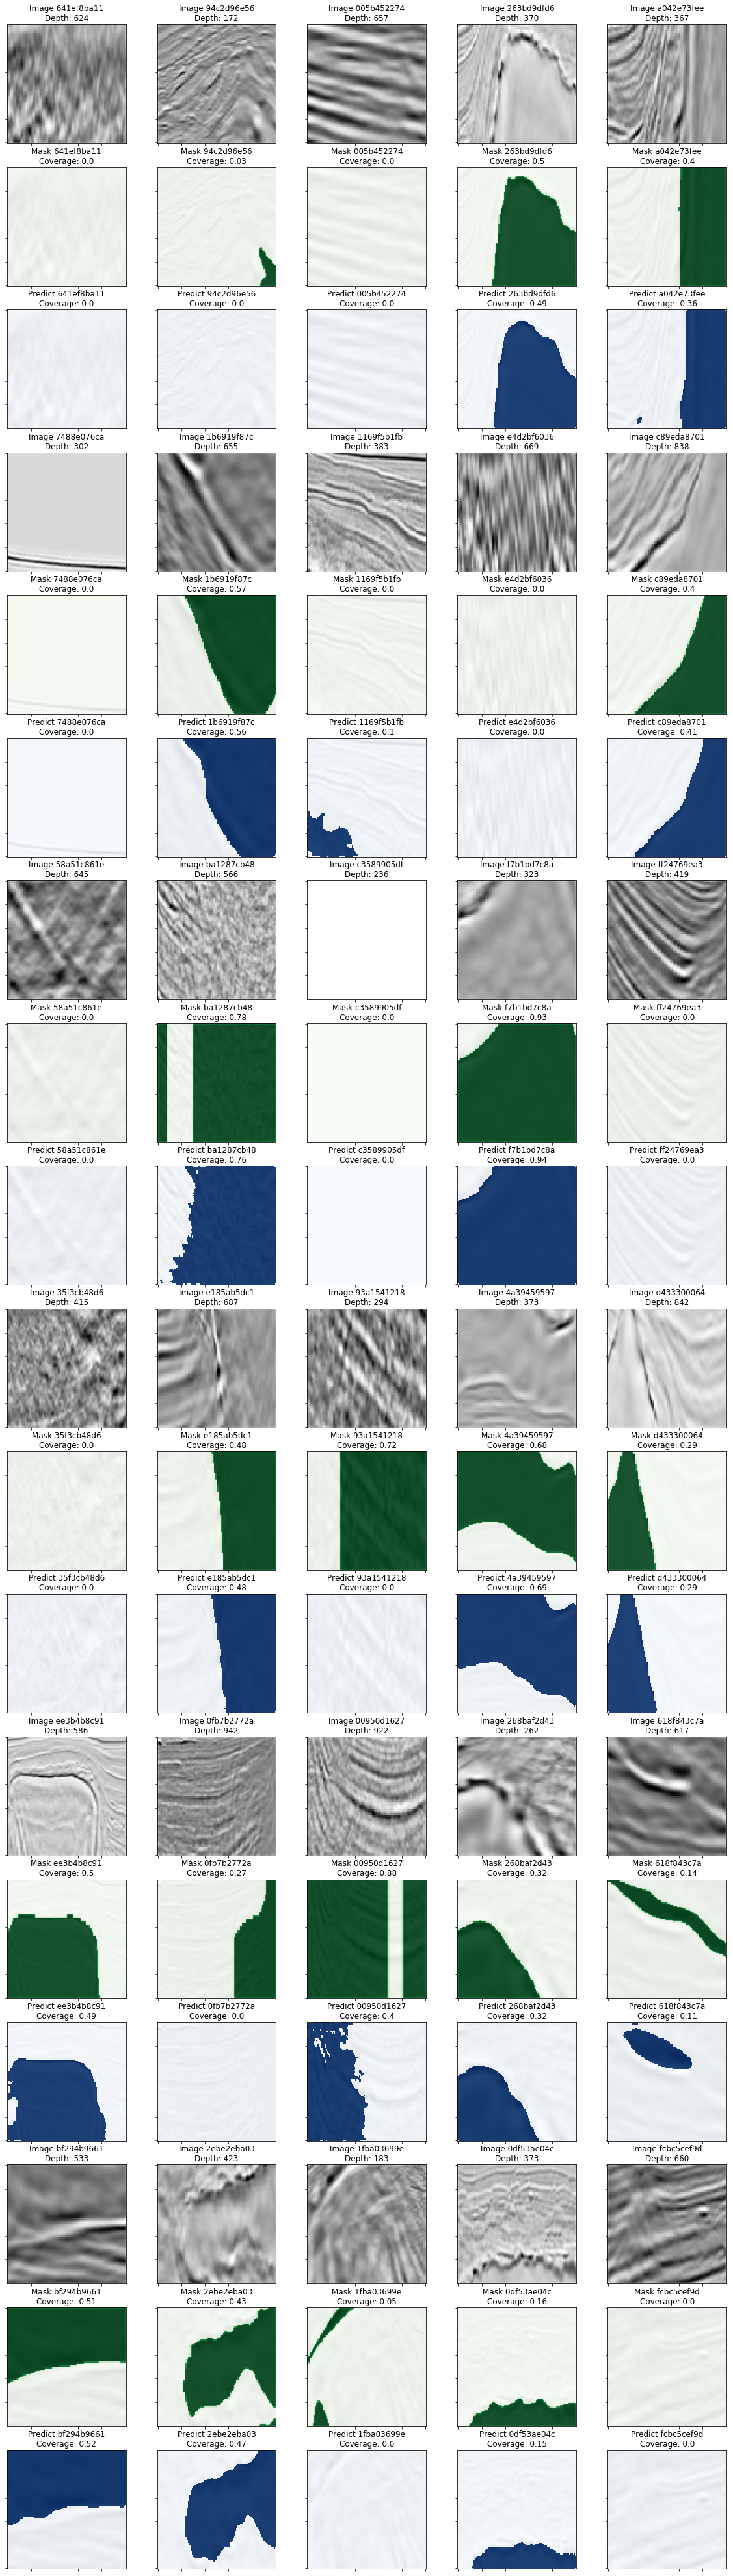

In [35]:
max_images = 30
grid_width = 5
grid_height = int(max_images / grid_width)*3
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width*4, grid_height*4))
for i, idx in enumerate(ids_valid[:max_images]):
    #print(idx)
    img = downsample(np.squeeze(x_valid[i]))
    mask = np.squeeze(mask_valid[i])
    pred = np.squeeze(preds_valid[i]>threshold_best)
    ax_image = axs[int(i / grid_width)*3, i % grid_width]
    ax_image.imshow(img, cmap="Greys")
    ax_image.set_title("Image {0}\nDepth: {1}".format(idx, train_df.loc[idx].z))
    ax_image.set_yticklabels([])
    ax_image.set_xticklabels([])
    ax_mask = axs[int(i / grid_width)*3+1, i % grid_width]
    ax_mask.imshow(img, cmap="Greys")
    ax_mask.imshow(mask, alpha=0.9, cmap="Greens")
    ax_mask.set_title("Mask {0}\nCoverage: {1}".format(idx,  round(train_df.loc[idx].coverage, 2)))
    ax_mask.set_yticklabels([])
    ax_mask.set_xticklabels([])
    ax_pred = axs[int(i / grid_width)*3+2, i % grid_width]
    ax_pred.imshow(img, cmap="Greys")
    ax_pred.imshow(pred, alpha=0.9, cmap="Blues")
    coverage_pred = np.sum(pred) / pow(img_size_ori, 2)
    ax_pred.set_title("Predict {0}\nCoverage: {1}".format(idx,  round(coverage_pred, 2)))
    ax_pred.set_yticklabels([])
    ax_pred.set_xticklabels([])

c:\applications\miniconda3\envs\tensorflow-gpu\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


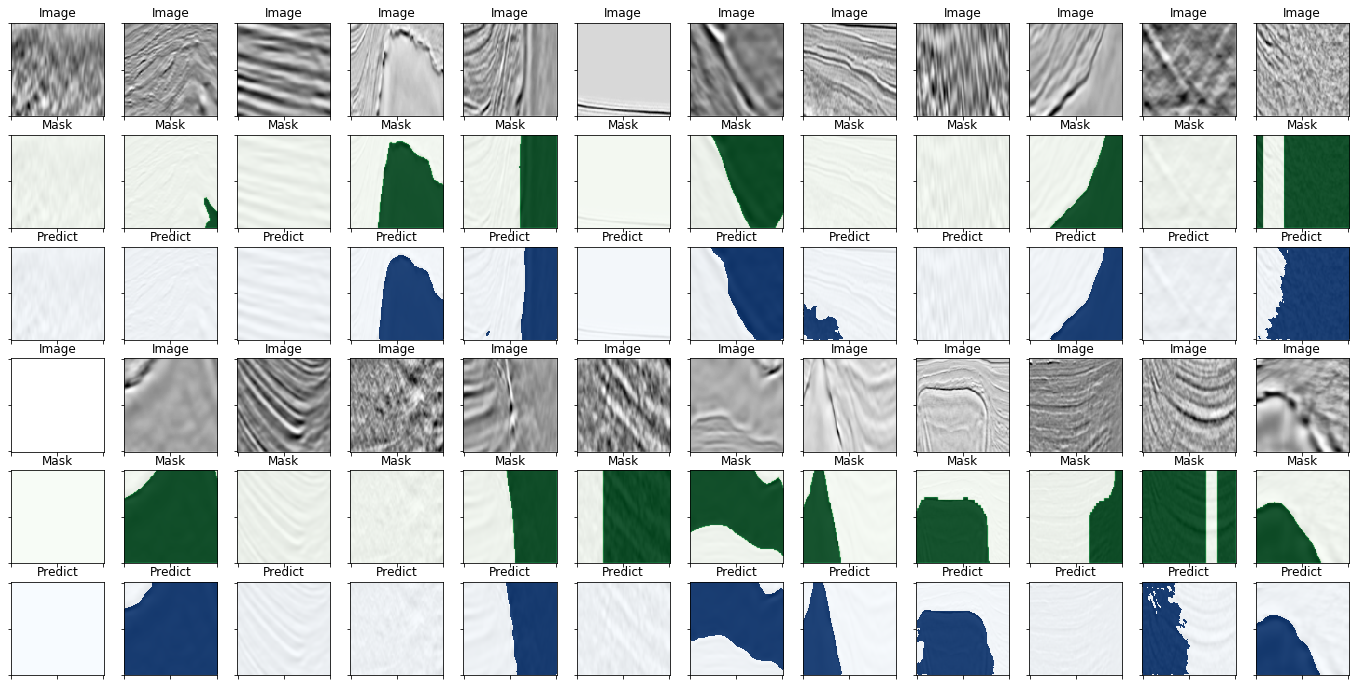

In [36]:
# plot small charts
max_images = 24
grid_width = 12
grid_height = int(max_images / grid_width)*3
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width*2, grid_height*2))
for i, idx in enumerate(ids_valid[:max_images]):
    #print(idx)
    img = downsample(np.squeeze(x_valid[i]))
    mask = np.squeeze(mask_valid[i])
    pred = np.squeeze(preds_valid[i]>threshold_best)
    ax_image = axs[int(i / grid_width)*3, i % grid_width]
    ax_image.imshow(img, cmap="Greys")
    ax_image.set_title("Image")
    ax_image.set_yticklabels([])
    ax_image.set_xticklabels([])
    ax_mask = axs[int(i / grid_width)*3+1, i % grid_width]
    ax_mask.imshow(img, cmap="Greys")
    ax_mask.imshow(mask, alpha=0.9, cmap="Greens")
    ax_mask.set_title("Mask")
    ax_mask.set_yticklabels([])
    ax_mask.set_xticklabels([])
    ax_pred = axs[int(i / grid_width)*3+2, i % grid_width]
    ax_pred.imshow(img, cmap="Greys")
    ax_pred.imshow(pred, alpha=0.9, cmap="Blues")
    coverage_pred = np.sum(pred) / pow(img_size_ori, 2)
    ax_pred.set_title("Predict")
    ax_pred.set_yticklabels([])
    ax_pred.set_xticklabels([])

## Submission
Load, predict and submit the test image predictions.

In [27]:
x_test = np.array([upsample(np.array(load_img(os.path.join(test_images_path, "{}.png").format(idx), color_mode = "grayscale"))) / 255 for idx in tqdm_notebook(test_df.index)]).reshape(-1, img_size_target, img_size_target, 1)

/home/mhew/apps/miniconda3/envs/tf/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [28]:
preds_test = model.predict(x_test)

In [29]:
pred_dict = {idx: RLenc(np.round(downsample(preds_test[i]) > threshold_best)) for i, idx in enumerate(tqdm_notebook(test_df.index.values))}

/home/mhew/apps/miniconda3/envs/tf/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [33]:
import datetime
data_folder_submissions = os.path.join(data_folder, 'submissions')
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv(os.path.join(data_folder_submissions, 'submission.csv'))
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M")
print('Submission output to: sub-{}.csv'.format(timestamp))
sub.to_csv(os.path.join(data_folder_submissions, "sub-{}.csv".format(timestamp)))

Submission output to: sub-20180824-0740.csv


## Appendix 1 - Environment Configuration

In [10]:
print (os.getcwd())
print (sys.version)
print (sys.executable)
print (sys.path)

D:\Development\DataScience\Learning\Kaggle TGS Salt Identification Challenge\notebooks\eda
3.6.5 |Anaconda, Inc.| (default, Mar 29 2018, 13:32:41) [MSC v.1900 64 bit (AMD64)]
c:\applications\miniconda3\envs\tensorflow-gpu\python.exe
['D:\\Development\\DataScience\\Learning\\Kaggle TGS Salt Identification Challenge\\src', '', 'c:\\applications\\miniconda3\\envs\\tensorflow-gpu\\python36.zip', 'c:\\applications\\miniconda3\\envs\\tensorflow-gpu\\DLLs', 'c:\\applications\\miniconda3\\envs\\tensorflow-gpu\\lib', 'c:\\applications\\miniconda3\\envs\\tensorflow-gpu', 'c:\\applications\\miniconda3\\envs\\tensorflow-gpu\\lib\\site-packages', 'c:\\applications\\miniconda3\\envs\\tensorflow-gpu\\lib\\site-packages\\object_detection-0.1-py3.6.egg', 'c:\\applications\\miniconda3\\envs\\tensorflow-gpu\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\mark_\\.ipython']
